In [1]:
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

# Configuration
DISTANCE_BIN_MI = 0.5  # Fixed bin size in miles
TIME_BIN_SIZE_MIN = 1  # Match original

# File paths
STATION_MAP_FILE = "../data/a_line_station_distances.csv"
ARRIVALS_FILE = "../data/nyc_subway_a_line_arrivals_2025.csv"
OUTPUT_HEADWAY_FILE = "../data/headway_matrix_distance.npy"
OUTPUT_SCHEDULE_FILE = "../data/schedule_matrix_distance.npy"
OUTPUT_GRID_FILE = "../data/distance_grid.csv"

In [2]:
# 1. Load Station Data and Analyze Spacing

station_map = pd.read_csv(STATION_MAP_FILE)
stations = station_map[station_map['location_type'] == 1][
    ['sequence_id', 'stop_id', 'stop_name', 'distance_from_start_mi']
].drop_duplicates().sort_values('distance_from_start_mi', ascending=False).reset_index(drop=True)

print(f"Loaded {len(stations)} stations")
print(f"Distance range: {stations['distance_from_start_mi'].min():.2f} - {stations['distance_from_start_mi'].max():.2f} miles")

# Calculate gaps
stations['gap_mi'] = stations['distance_from_start_mi'].diff().abs()
print(f"\nStation spacing stats:")
print(f"  Mean: {stations['gap_mi'].mean():.3f} mi")
print(f"  Std:  {stations['gap_mi'].std():.3f} mi")
print(f"  Min:  {stations['gap_mi'].min():.3f} mi")
print(f"  Max:  {stations['gap_mi'].max():.3f} mi")

stations.head(10)

Loaded 66 stations
Distance range: 0.00 - 32.20 miles

Station spacing stats:
  Mean: 0.495 mi
  Std:  0.449 mi
  Min:  0.000 mi
  Max:  3.675 mi


,sequence_id,stop_id,stop_name,distance_from_start_mi,gap_mi
0,0,A02,Inwood-207 St,32.199699,NaN
1,1,A03,Dyckman St,31.774254,0.425445
2,2,A05,190 St,31.188895,0.585360
3,3,A06,181 St,30.641013,0.547882
4,4,A07,175 St,30.330511,0.310501
5,5,A09,168 St,29.845248,0.485263
6,6,A10,163 St-Amsterdam Av,29.518309,0.326939
7,7,A11,155 St,29.126558,0.391750
8,8,A12,145 St,28.704759,0.421799
9,9,A14,135 St,28.195908,0.508851


In [3]:
# 2. Create Fixed Distance Grid

min_dist = stations['distance_from_start_mi'].min()
max_dist = stations['distance_from_start_mi'].max()

# Create regular grid
distance_bins = np.arange(min_dist, max_dist + DISTANCE_BIN_MI, DISTANCE_BIN_MI)
num_bins = len(distance_bins)

print(f"Fixed distance grid:")
print(f"  Bin size: {DISTANCE_BIN_MI} miles")
print(f"  Range: {distance_bins[0]:.2f} - {distance_bins[-1]:.2f} miles")
print(f"  Number of bins: {num_bins}")
print(f"  (vs {len(stations)} stations originally)")

# Save grid for reference
grid_df = pd.DataFrame({
    'bin_id': range(num_bins),
    'distance_mi': distance_bins
})
grid_df.to_csv(OUTPUT_GRID_FILE, index=False)
print(f"\nSaved grid to {OUTPUT_GRID_FILE}")

Fixed distance grid:
  Bin size: 0.5 miles
  Range: 0.00 - 32.50 miles
  Number of bins: 66
  (vs 66 stations originally)

Saved grid to ../data/distance_grid.csv


In [ ]:
# 3. Load Arrivals and Map to Station Distances

arrivals_df = pd.read_csv(ARRIVALS_FILE)
arrivals_df['arrival_time'] = pd.to_datetime(arrivals_df['arrival_time'])

# Arrivals have directional stop_ids (e.g. A38S, A06N), stations have parent IDs (A38, A06)
# Strip the N/S suffix to match
arrivals_df['parent_stop_id'] = arrivals_df['stop_id'].str.replace(r'[NS]$', '', regex=True)

# Map parent_stop_id to distance
stop_to_dist = dict(zip(stations['stop_id'], stations['distance_from_start_mi']))
arrivals_df = arrivals_df[arrivals_df['parent_stop_id'].isin(stop_to_dist.keys())].copy()
arrivals_df['distance_mi'] = arrivals_df['parent_stop_id'].map(stop_to_dist)

# Direction mapping (from directional stop_id suffix)
arrivals_df['direction_idx'] = arrivals_df['stop_id'].str[-1].map({'N': 0, 'S': 1})

print(f"Loaded {len(arrivals_df):,} arrivals")
arrivals_df.head()

Loaded 2,097,004 arrivals


,trip_uid,route_id,direction,stop_id,stop_name,stop_lat,stop_lon,arrival_time,parent_stop_id,distance_mi,direction_idx
0,1749151110_A..S57R,A,S,A38S,Fulton St,40.710197,-74.007691,2025-06-06 00:00:00+00:00,A38,19.795857,1
1,1749153120_A..N55R,A,N,H06N,Beach 67 St,40.590927,-73.796924,2025-06-06 00:00:02+00:00,H06,2.478227,0
2,1749149220_A..S58R,A,S,H03S,Howard Beach-JFK Airport,40.660476,-73.830301,2025-06-06 00:00:07+00:00,H03,8.007467,1
3,1749153300_A..S57R,A,S,A06S,181 St,40.851695,-73.937969,2025-06-06 00:00:17+00:00,A06,30.641013,1
4,1749147750_A..S58R,A,S,H11S,Far Rockaway-Mott Av,40.603995,-73.755405,2025-06-06 00:00:23+00:00,H11,0.000000,1


In [6]:
# 4. Pivot to (Time, Distance, Direction) - Station-based first

arrivals_df['arrival_ts'] = arrivals_df['arrival_time']

# Pivot by distance (using actual station distances)
pivot_df = arrivals_df.pivot_table(
    index='arrival_time',
    columns=['distance_mi', 'direction_idx'],
    values='arrival_ts',
    aggfunc='last'
)

# Resample to 1-minute
resampled_df = pivot_df.resample(f'{TIME_BIN_SIZE_MIN}min').last()
print(f"Resampled shape: {resampled_df.shape}")

# Forward fill arrivals (temporal)
filled_df = resampled_df.ffill(limit=30)

# Calculate headways
current_time = filled_df.index.to_series()
headway_station_df = filled_df.apply(lambda col: current_time - col) / pd.Timedelta(minutes=1)
headway_station_df = headway_station_df.clip(lower=0, upper=30)

print(f"Station-based headway shape: {headway_station_df.shape}")

Resampled shape: (264222, 129)
Station-based headway shape: (264222, 129)


In [8]:
# 5. Interpolate to Fixed Distance Grid

# Get unique station distances (sorted)
station_distances = sorted(stations['distance_from_start_mi'].unique())

print("Interpolating to fixed distance grid...")
print(f"  From: {len(station_distances)} stations")
print(f"  To: {num_bins} distance bins")

# Prepare output array: (Time, Bins, Directions)
num_times = len(headway_station_df)
headway_distance = np.zeros((num_times, num_bins, 2))

for dir_idx in [0, 1]:
    # Get columns for this direction
    dir_cols = [c for c in headway_station_df.columns if c[1] == dir_idx]
    dir_distances = sorted([c[0] for c in dir_cols])
    
    if len(dir_distances) < 2:
        print(f"  Warning: Direction {dir_idx} has < 2 stations, skipping")
        continue
    
    # Extract headway values for this direction: (Time, Stations)
    dir_headways = headway_station_df[[c for c in dir_cols]].values
    
    # For each timestep, interpolate across distance
    for t in range(num_times):
        station_values = dir_headways[t, :]
        
        # Skip if all NaN
        valid_mask = ~np.isnan(station_values)
        if valid_mask.sum() < 2:
            continue
        
        valid_dists = np.array(dir_distances)[valid_mask]
        valid_vals = station_values[valid_mask]
        
        # Linear interpolation with extrapolation
        f = interpolate.interp1d(
            valid_dists, valid_vals,
            kind='linear',
            bounds_error=False,
            fill_value=(valid_vals[0], valid_vals[-1])  # Extrapolate edges
        )
        
        headway_distance[t, :, dir_idx] = f(distance_bins)
    
    print(f"  Direction {dir_idx}: Done")

# Fill any remaining NaN with 0
headway_distance = np.nan_to_num(headway_distance, nan=0.0)
headway_distance = np.clip(headway_distance, 0, 30)

print(f"\nFinal shape: {headway_distance.shape}")
print(f"  (Time={num_times}, Bins={num_bins}, Directions=2)")

Interpolating to fixed distance grid...
  From: 65 stations
  To: 66 distance bins
  Direction 0: Done
  Direction 1: Done

Final shape: (264222, 66, 2)
  (Time=264222, Bins=66, Directions=2)


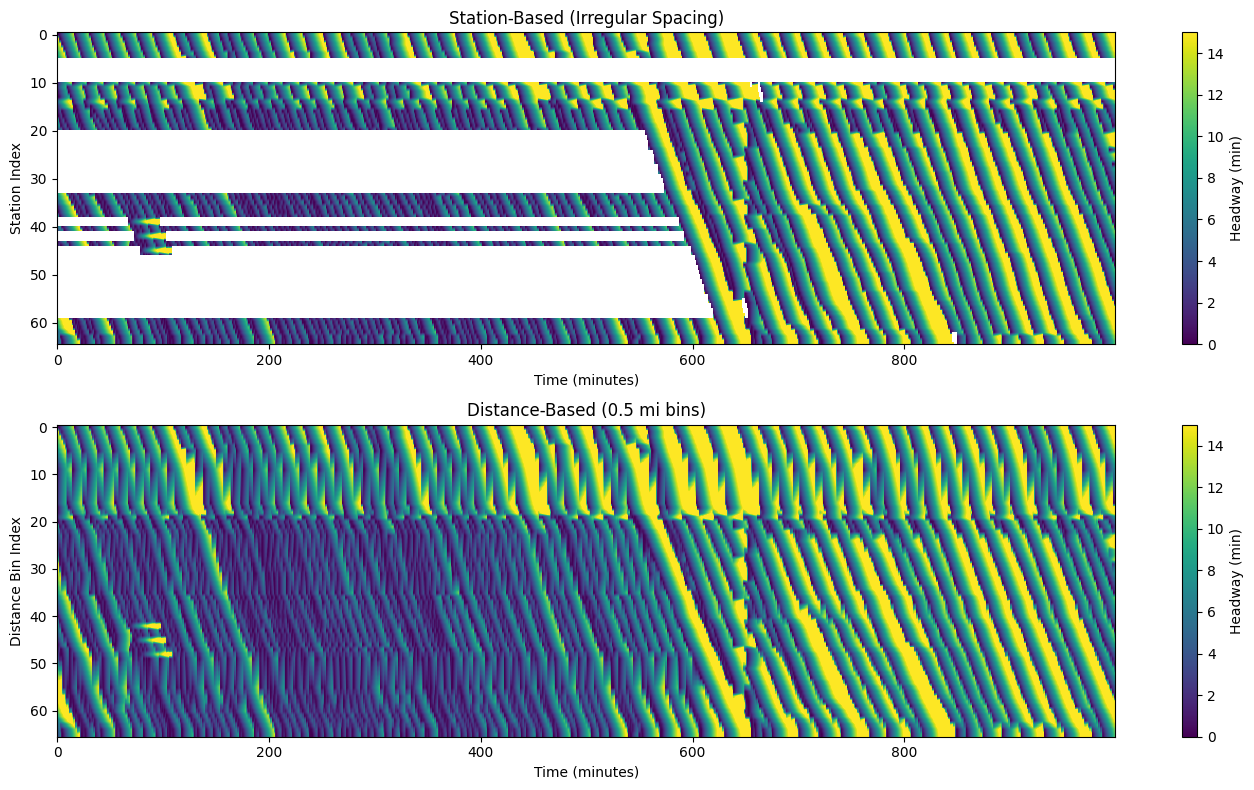

In [9]:
# 6. Visualize: Compare Station-Based vs Distance-Based

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Pick a sample time range (e.g., 1000 timesteps starting at index 50000)
t_start, t_len = 50000, 1000
sample_dir = 0  # North

# Station-based (original)
ax1 = axes[0]
orig_cols = sorted([c for c in headway_station_df.columns if c[1] == sample_dir], key=lambda x: x[0])
orig_dists = [c[0] for c in orig_cols]
orig_data = headway_station_df.iloc[t_start:t_start+t_len][orig_cols].values.T

im1 = ax1.imshow(orig_data, aspect='auto', cmap='viridis', vmin=0, vmax=15)
ax1.set_title('Station-Based (Irregular Spacing)')
ax1.set_xlabel('Time (minutes)')
ax1.set_ylabel('Station Index')
plt.colorbar(im1, ax=ax1, label='Headway (min)')

# Distance-based (new)
ax2 = axes[1]
new_data = headway_distance[t_start:t_start+t_len, :, sample_dir].T

im2 = ax2.imshow(new_data, aspect='auto', cmap='viridis', vmin=0, vmax=15)
ax2.set_title(f'Distance-Based ({DISTANCE_BIN_MI} mi bins)')
ax2.set_xlabel('Time (minutes)')
ax2.set_ylabel('Distance Bin Index')
plt.colorbar(im2, ax=ax2, label='Headway (min)')

plt.tight_layout()
plt.savefig('../images/distance_vs_station_binning.png', dpi=150)
plt.show()

In [10]:
# 7. Process Schedule (same terminal schedule, just match time index)

schedule_df = pd.read_csv("../data/target_terminal_headways.csv")

if 'direction_id' in schedule_df.columns:
    schedule_df = schedule_df.rename(columns={'direction_id': 'direction_idx'})

schedule_df['service_date_dt'] = pd.to_datetime(schedule_df['service_date'])
schedule_df['departure_dt'] = schedule_df['service_date_dt'] + pd.to_timedelta(schedule_df['departure_seconds'], unit='s')
schedule_df['departure_dt'] = schedule_df['departure_dt'].dt.tz_localize('UTC')

sched_pivot = schedule_df.pivot_table(
    index='departure_dt',
    columns='direction_idx',
    values='scheduled_headway_min',
    aggfunc='mean'
)

sched_resampled = sched_pivot.resample(f'{TIME_BIN_SIZE_MIN}min').ffill()
sched_aligned = sched_resampled.reindex(headway_station_df.index).ffill().fillna(0)

for d in [0, 1]:
    if d not in sched_aligned.columns:
        sched_aligned[d] = 0

sched_aligned = sched_aligned[[0, 1]]
sched_matrix = sched_aligned.values.reshape(-1, 2, 1)

print(f"Schedule matrix shape: {sched_matrix.shape}")

Schedule matrix shape: (264222, 2, 1)


In [11]:
# 8. Save Outputs

# Add channel dimension: (Time, Bins, Directions) -> (Time, Bins, Directions, 1)
headway_out = headway_distance.reshape(num_times, num_bins, 2, 1)

np.save(OUTPUT_HEADWAY_FILE, headway_out)
np.save(OUTPUT_SCHEDULE_FILE, sched_matrix)

print(f"Saved headway matrix: {OUTPUT_HEADWAY_FILE}")
print(f"  Shape: {headway_out.shape}")
print(f"Saved schedule matrix: {OUTPUT_SCHEDULE_FILE}")
print(f"  Shape: {sched_matrix.shape}")

print(f"\n✅ Distance-based matrices ready!")
print(f"   Update config.py:")
print(f"   - NUM_STATIONS = {num_bins}")
print(f"   - HEADWAY_FILE = 'headway_matrix_distance.npy'")
print(f"   - SCHEDULE_FILE = 'schedule_matrix_distance.npy'")

Saved headway matrix: ../data/headway_matrix_distance.npy
  Shape: (264222, 66, 2, 1)
Saved schedule matrix: ../data/schedule_matrix_distance.npy
  Shape: (264222, 2, 1)

✅ Distance-based matrices ready!
   Update config.py:
   - NUM_STATIONS = 66
   - HEADWAY_FILE = 'headway_matrix_distance.npy'
   - SCHEDULE_FILE = 'schedule_matrix_distance.npy'


In [12]:
# 9. Validation: Check data quality

print("=" * 60)
print("DATA QUALITY VALIDATION")
print("=" * 60)

zero_frac = (headway_out == 0).sum() / headway_out.size
print(f"\nZero fraction: {zero_frac:.2%}")

non_zero = headway_out[headway_out > 0]
print(f"Non-zero headway stats:")
print(f"  Mean: {non_zero.mean():.2f} min")
print(f"  Std:  {non_zero.std():.2f} min")
print(f"  Min:  {non_zero.min():.2f} min")
print(f"  Max:  {non_zero.max():.2f} min")

print(f"\nShape comparison:")
print(f"  Station-based: (T, 66, 2, 1)")
print(f"  Distance-based: {headway_out.shape}")

DATA QUALITY VALIDATION

Zero fraction: 0.98%
Non-zero headway stats:
  Mean: 6.92 min
  Std:  5.77 min
  Min:  0.00 min
  Max:  30.00 min

Shape comparison:
  Station-based: (T, 66, 2, 1)
  Distance-based: (264222, 66, 2, 1)
